In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from scipy.stats import ttest_1samp
from sklearn.base import clone
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import scale
from hidimstat import CPI, PFI, LOCO
from sage import PermutationEstimator, MarginalImputer, DefaultImputer

random_seed = 42
rng = np.random.RandomState(random_seed)
n_folds = 5

## Load the California housing dataset and add a spurious feature
The California housing dataset is a regression dataset with 8 features. We add a
spurious feature that is a linear combination of 3 features plus some noise.
The spurious feature does not provide any additional information about the target.



The dataset contains 6879 samples and 10 features.


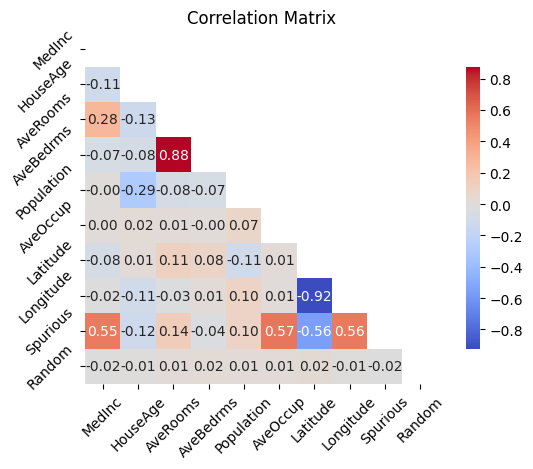

In [3]:
dataset = fetch_california_housing()
X_, y_ = dataset.data, dataset.target
# only use 2/3 of samples to speed up the example
X, _, y, _ = train_test_split(X_, y_, test_size=0.6667, random_state=rng, shuffle=True)

redundant_coef = rng.choice(np.arange(X.shape[1]), size=(3,), replace=False)
X_spurious = scale(X[:, redundant_coef]).sum(axis=1)
X_spurious += rng.normal(0, scale=np.std(X_spurious) * 0.25, size=X.shape[0])
X_random = rng.normal(0, 0.5, size=X.shape[0])
X = np.hstack([X, X_spurious[:, np.newaxis], X_random[:, np.newaxis]])
feature_names = dataset.feature_names + ["Spurious"] + ["Random"]
print(f"The dataset contains {X.shape[0]} samples and {X.shape[1]} features.")

# Compute the correlation matrix
correlation_matrix = np.corrcoef(X, rowvar=False)

# Plot the lower triangle of the correlation matrix
fig, ax = plt.subplots()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(
    correlation_matrix,
    mask=mask,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    square=True,
    cbar_kws={"shrink": 0.8},
    ax=ax,
)
ax.set_title("Correlation Matrix")
ax.set_yticks(
    np.arange(len(feature_names)) + 0.5, labels=feature_names, fontsize=10, rotation=45
)
ax.set_xticks(
    np.arange(len(feature_names)) + 0.5, labels=feature_names, fontsize=10, rotation=45
)
plt.tight_layout()
plt.show()

## Fit a predictive model
We fit a neural network model to the California housing dataset. PFI is a
model-agnostic method, we therefore illustrate its behavior when using a neural
network model.



In [4]:
fitted_estimators = []
train_scores = []
test_scores = []

model = RandomForestRegressor(
    n_estimators=100,
    oob_score=True,
    n_jobs=-1,
    random_state=rng,
    max_features=1.0,
    min_samples_leaf=1,
)

kf = KFold(n_splits=n_folds, shuffle=True, random_state=rng)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model_c = clone(model)

    model_c = model_c.fit(X_train, y_train)
    fitted_estimators.append(model_c)
    y_pred_train = model_c.predict(X_train)
    y_pred_test = model_c.predict(X_test)
    train_scores.append(r2_score(y_train, y_pred_train))
    test_scores.append(r2_score(y_test, y_pred_test))

print(f"Cross-validation R2 score on train: {np.mean(train_scores):.3f} ± {np.std(train_scores):.3f}")
print(f"Cross-validation R2 score on test: {np.mean(test_scores):.3f} ± {np.std(test_scores):.3f}")

Cross-validation R2 score on train: 0.968 ± 0.001
Cross-validation R2 score on test: 0.771 ± 0.017


### Inspect the impact of the `max_feature` parameter on the various feature importance measures: MDI, UMDI, PFI, CPI, SAGE, LOCO

In [17]:
# Store all results
mdi_data = []
umdi_data = []
pfi_data = []
cpi_data = []
loco_data = []
sage_data = []
sage_nan_data = []

scoring_function = mean_squared_error
column_names = feature_names + ["importance sum", "Total MSE improvement"]
n_cols = len(column_names)
n_features = len(feature_names)
max_val = 0
mdi_attr = "_unnormalized_feature_importances" if hasattr(fitted_estimators[0], "_unnormalized_feature_importances") else "feature_importances_"

# Loop over all max_features from 1 to 10
for mf in range(1, n_features + 1):
    all_fold_mdi = []
    all_fold_umdi = []
    all_fold_pfi = []
    all_fold_cpi = []
    all_fold_loco = []
    all_fold_sage = []
    all_fold_sage_nan = []

    print(f"computing values for mf = {mf} ...")
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Clone model and set max_features
        model = clone(fitted_estimators[i])
        model.set_params(max_features=mf)
        model.fit(X_train, y_train)
        test_score_diff = scoring_function(np.repeat(y_test.mean(), y_test.shape), y_test) - scoring_function(model.predict(X_test), y_test)

        # Compute biased & unbiased MDI
        mdi_imp = getattr(model, mdi_attr)
        umdi_imp = model.unbiased_feature_importances_
        all_fold_mdi.append(np.append(mdi_imp, [mdi_imp.sum(), test_score_diff]))
        all_fold_umdi.append(np.append(umdi_imp, [umdi_imp.sum(), test_score_diff]))
        
        # Compute PFI
        pfi = PFI(
            model,
            n_permutations=20,
            loss = mean_squared_error,
            random_state=rng,
        )
        pfi.fit(X_train, y_train)
        pfi_imp = pfi.importance(X_test, y_test)["importance"]
        all_fold_pfi.append(np.append(pfi_imp, [pfi_imp.sum(), test_score_diff]))

        # Compute CPI
        cpi = CPI(
            model,
            imputation_model_continuous=RidgeCV(alphas=np.logspace(-3, 3, 5)),
            loss = mean_squared_error,
            random_state=rng,
        )
        cpi.fit(X_train, y_train)
        cpi_imp = cpi.importance(X_test, y_test)["importance"]
        all_fold_cpi.append(np.append(cpi_imp, [cpi_imp.sum(), test_score_diff]))

        # Compute LOCO
        loco = LOCO(
            model,
            loss = mean_squared_error,
        )
        loco.fit(X_train, y_train)
        loco_imp = loco.importance(X_test, y_test)["importance"]
        all_fold_loco.append(np.append(loco_imp, [loco_imp.sum(), test_score_diff]))

        # Compute SAGE
        imputer = MarginalImputer(model, X_test[:500,:])
        sage = PermutationEstimator(
            imputer, "mse", random_state=rng
        )
        sage_imp = sage(X_test, y_test, bar=False, n_permutations=30).values
        all_fold_sage.append(np.append(sage_imp, [sage_imp.sum(), test_score_diff]))

        # Compute SAGE with the default imputer and nan values
        imputer = DefaultImputer(model, np.repeat(np.nan, X_test.shape[1]))
        sage_nan = PermutationEstimator(
            imputer, "mse", random_state=rng
        )
        sage_nan_imp = sage_nan(X_test, y_test, bar=False, n_permutations=30).values
        all_fold_sage_nan.append(np.append(sage_nan_imp, [sage_nan_imp.sum(), test_score_diff]))

    # Stack fold-level importances
    all_fold_mdi = np.stack(all_fold_mdi)
    all_fold_umdi = np.stack(all_fold_umdi)
    all_fold_pfi = np.stack(all_fold_pfi)
    all_fold_cpi = np.stack(all_fold_cpi)
    all_fold_loco = np.stack(all_fold_loco)
    all_fold_sage = np.stack(all_fold_sage)
    all_fold_sage_nan = np.stack(all_fold_sage_nan)

    temp_max = np.max([all_fold_mdi, all_fold_umdi, all_fold_pfi, all_fold_cpi])
    max_val = max(max_val, temp_max)
    # Store importance data in long format
    mdi_data.append(
        pd.DataFrame(
            {
                "mdi": all_fold_mdi.ravel(),
                "method": [f"mf={mf}"] * (n_folds * n_cols),
                "feature": np.tile(column_names, n_folds),
                "fold": np.repeat(np.arange(n_folds), n_cols),
            }
        )
    )
    umdi_data.append(
        pd.DataFrame(
            {
                "umdi": all_fold_umdi.ravel(),
                "method": [f"mf={mf}"] * (n_folds * n_cols),
                "feature": np.tile(column_names, n_folds),
                "fold": np.repeat(np.arange(n_folds), n_cols),
            }
        )
    )
    pfi_data.append(
        pd.DataFrame(
            {
                "pfi": all_fold_pfi.ravel(),
                "method": [f"mf={mf}"] * (n_folds * n_cols),
                "feature": np.tile(column_names, n_folds),
                "fold": np.repeat(np.arange(n_folds), n_cols),
            }
        )
    )
    cpi_data.append(
        pd.DataFrame(
            {
                "cpi": all_fold_cpi.ravel(),
                "method": [f"mf={mf}"] * (n_folds * n_cols),
                "feature": np.tile(column_names, n_folds),
                "fold": np.repeat(np.arange(n_folds), n_cols),
            }
        )
    )
    loco_data.append(
        pd.DataFrame(
            {
                "loco": all_fold_loco.ravel(),
                "method": [f"mf={mf}"] * (n_folds * n_cols),
                "feature": np.tile(column_names, n_folds),
                "fold": np.repeat(np.arange(n_folds), n_cols),
            }
        )
    )
    sage_data.append(
        pd.DataFrame(
            {
                "sage": all_fold_sage.ravel(),
                "method": [f"mf={mf}"] * (n_folds * n_cols),
                "feature": np.tile(column_names, n_folds),
                "fold": np.repeat(np.arange(n_folds), n_cols),
            }
        )
    )
    sage_nan_data.append(
        pd.DataFrame(
            {
                "sage_nan": all_fold_sage_nan.ravel(),
                "method": [f"mf={mf}"] * (n_folds * n_cols),
                "feature": np.tile(column_names, n_folds),
                "fold": np.repeat(np.arange(n_folds), n_cols),
            }
        )
    )

# Combine data
df_val_mdi = pd.concat(mdi_data, ignore_index=True)
df_val_umdi = pd.concat(umdi_data, ignore_index=True)
df_val_pfi = pd.concat(pfi_data, ignore_index=True)
df_val_cpi = pd.concat(cpi_data, ignore_index=True)
df_val_loco = pd.concat(loco_data, ignore_index=True)
df_val_sage = pd.concat(sage_data, ignore_index=True)
df_val_sage_nan = pd.concat(sage_nan_data, ignore_index=True)

computing values for mf = 1 ...
computing values for mf = 2 ...
computing values for mf = 3 ...
computing values for mf = 4 ...
computing values for mf = 5 ...
computing values for mf = 6 ...
computing values for mf = 7 ...
computing values for mf = 8 ...
computing values for mf = 9 ...
computing values for mf = 10 ...


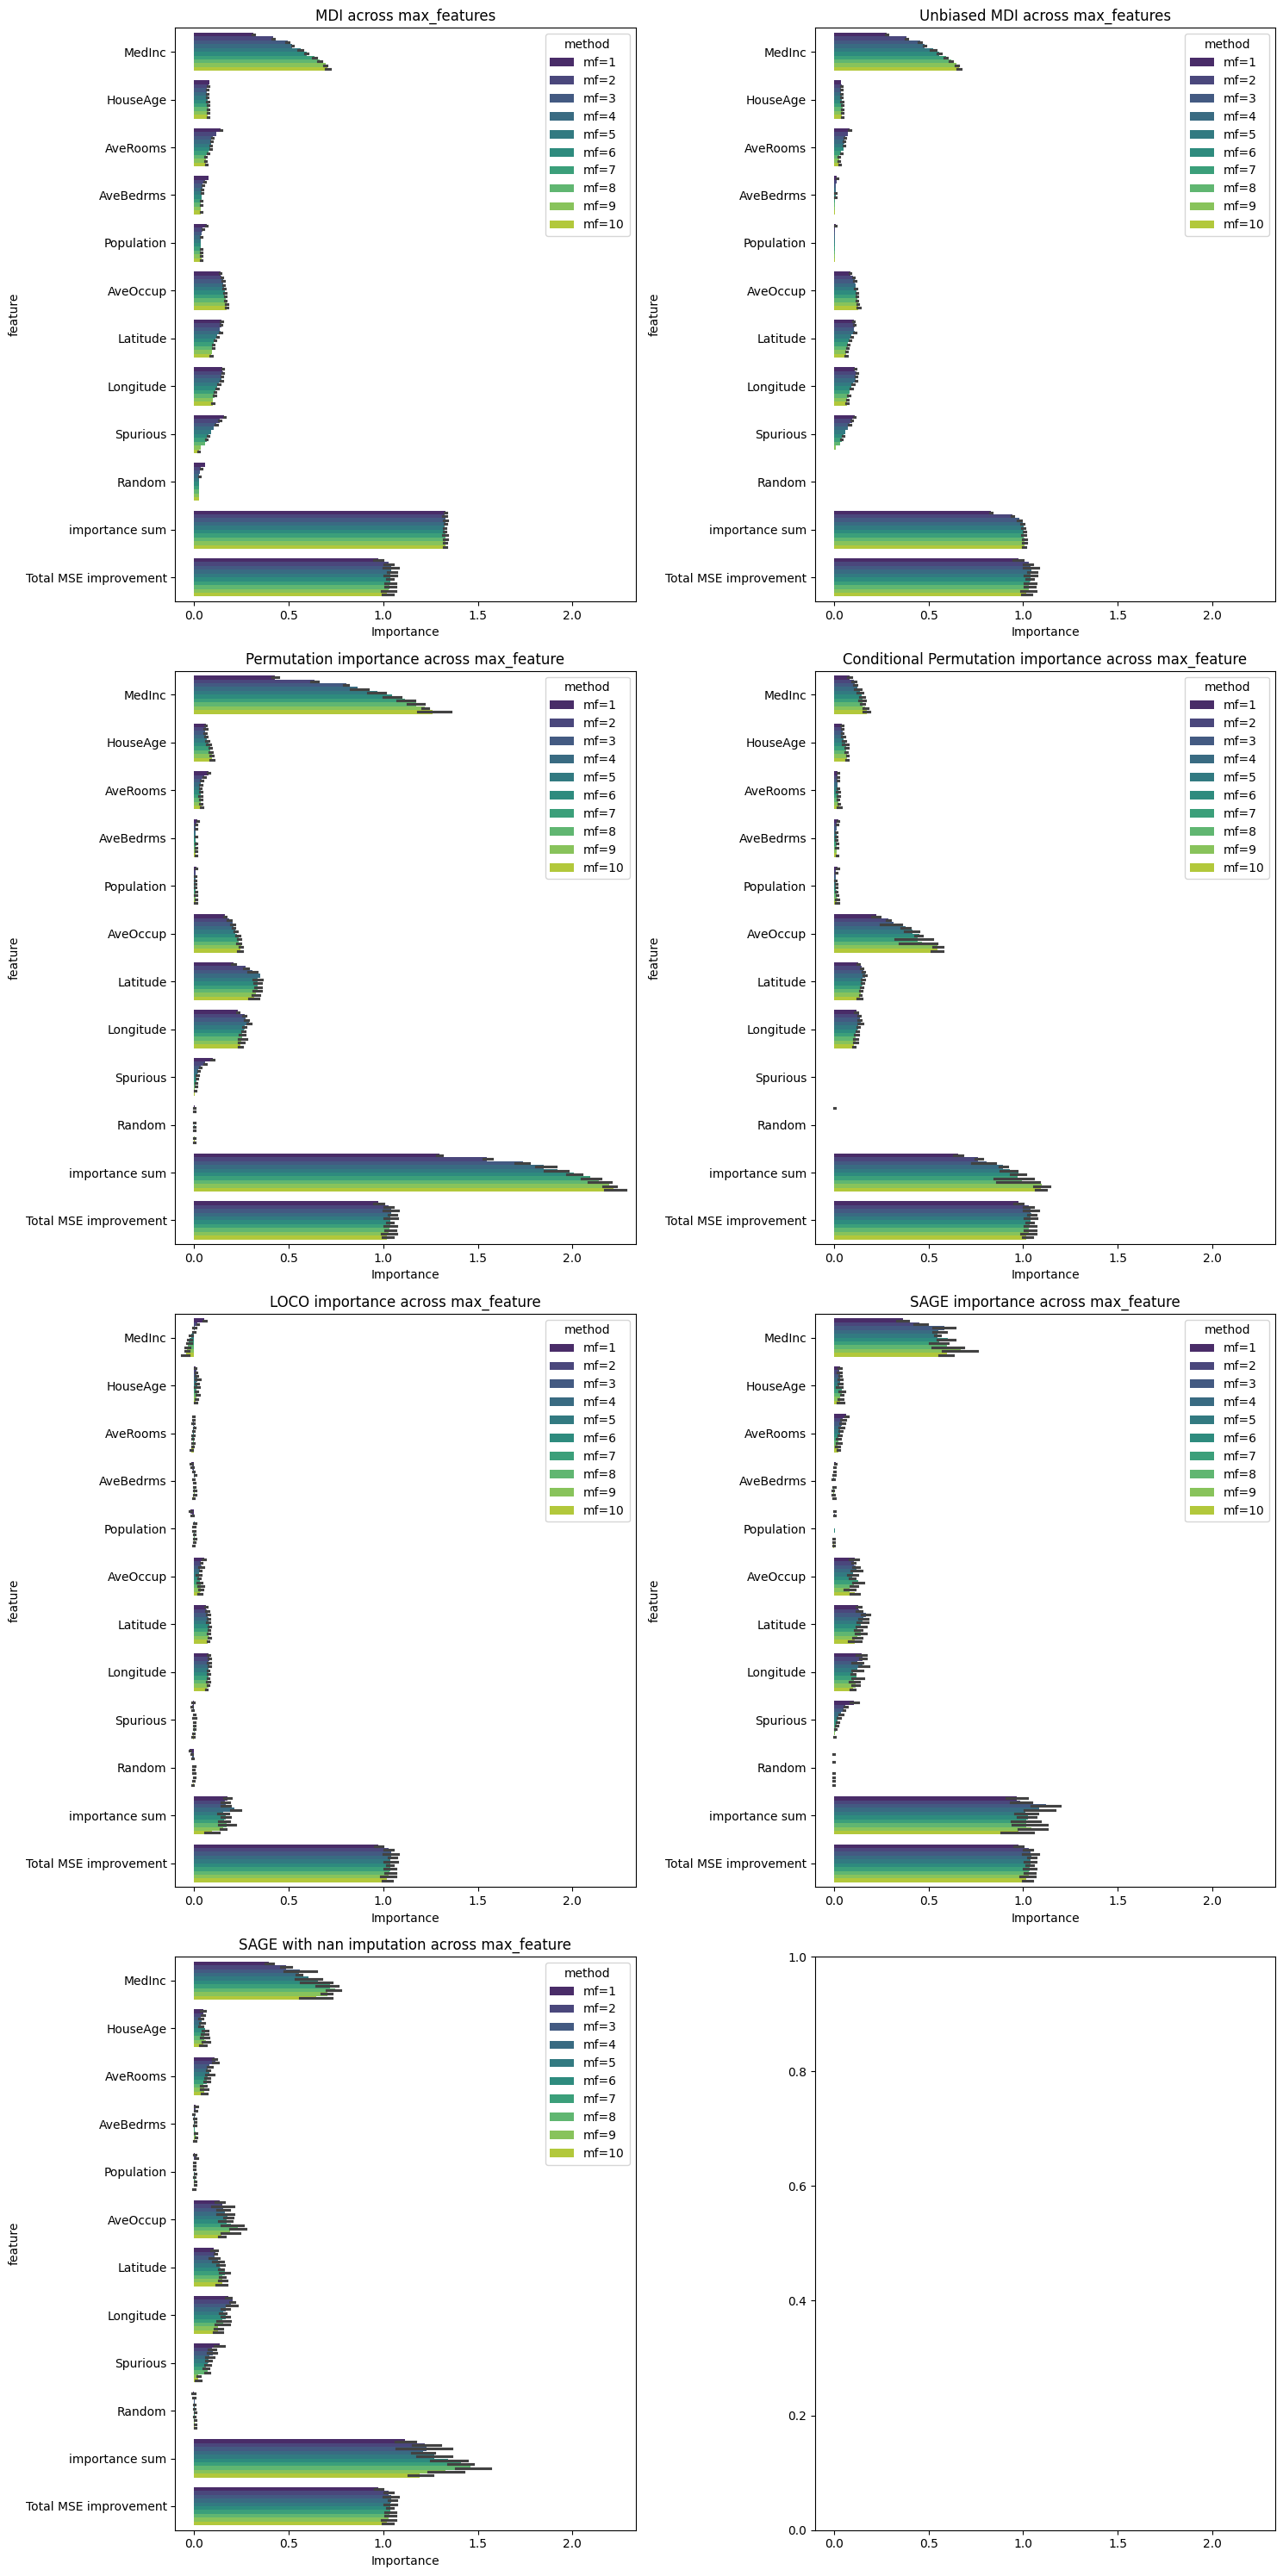

In [21]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 30))

for i in range(4):
    for j in range(2):
        ax[i,j].set_xlim(-0.1, max_val)

sns.barplot(
    data=df_val_mdi,
    x="mdi",
    y="feature",
    hue="method",
    errorbar="ci",
    palette="viridis",
    ax=ax[0,0],
)
ax[0,0].set_title("MDI across max_features")
ax[0,0].set_xlabel("Importance")

sns.barplot(
    data=df_val_umdi,
    x="umdi",
    y="feature",
    hue="method",
    errorbar="ci",
    palette="viridis",
    ax=ax[0,1],
)
ax[0,1].set_title("Unbiased MDI across max_features")
ax[0,1].set_xlabel("Importance")

sns.barplot(
    data=df_val_pfi,
    x="pfi",
    y="feature",
    hue="method",
    errorbar="ci",
    palette="viridis",
    ax=ax[1,0],
)
ax[1,0].set_title("Permutation importance across max_feature")
ax[1,0].set_xlabel("Importance")

sns.barplot(
    data=df_val_cpi,
    x="cpi",
    y="feature",
    hue="method",
    errorbar="ci",
    palette="viridis",
    ax=ax[1,1],
)
ax[1,1].set_title("Conditional Permutation importance across max_feature")
ax[1,1].set_xlabel("Importance")

sns.barplot(
    data=df_val_loco,
    x="loco",
    y="feature",
    hue="method",
    errorbar="ci",
    palette="viridis",
    ax=ax[2,0],
)
ax[2,0].set_title("LOCO importance across max_feature")
ax[2,0].set_xlabel("Importance")

sns.barplot(
    data=df_val_sage,
    x="sage",
    y="feature",
    hue="method",
    errorbar="ci",
    palette="viridis",
    ax=ax[2,1],
)
ax[2,1].set_title("SAGE importance across max_feature")
ax[2,1].set_xlabel("Importance")

sns.barplot(
    data=df_val_sage_nan,
    x="sage_nan",
    y="feature",
    hue="method",
    errorbar="ci",
    palette="viridis",
    ax=ax[3,0],
)
ax[3,0].set_title("SAGE with nan imputation across max_feature")
ax[3,0].set_xlabel("Importance")

plt.tight_layout()
plt.show()